# **Imports**

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# Plot figures
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# save figures
ROOT_DIR = "."
DIR      = "binary_classifier"
FIG_PATH = os.path.join(ROOT_DIR, "images", DIR)
NR28     = 28
NC28     = 28

os.makedirs(FIG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, fig_id + "." + fig_extension),\
                bbox_inches='tight',\
                pad_inches=0.09,\
                format=fig_extension,\
                dpi=resolution)

# **MNIST DATA - DIGITS [0-9]**

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape
# (70000, 784) -> 70.000 images with size = 28x28 (784 = 28 * 28)

(70000, 784)

In [ ]:
X[0].reshape(NR28, NC28)

In [ ]:
y.shape

(70000,)

In [ ]:
# Values in y-target are strings
# Check type of labels
print( "type(y): ", type(y) )
print( "type( y[0] ): ", type(y[0]))
y[:20]

type(y):  <class 'numpy.ndarray'>
type( y[0] ):  <class 'str'>


array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7', '2', '8', '6', '9'], dtype=object)

In [ ]:
# Convert y into intergers
y = y.astype(np.uint8)

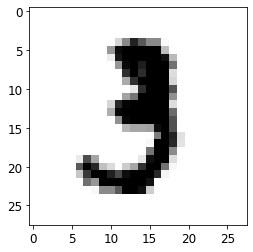

In [ ]:
# Plot an example
id_img = 10
img    = X[id_img]
img    = img.reshape(28, 28)

plt.imshow(img, cmap=mpl.cm.binary)
plt.show()

In [ ]:
# Check the true label of the image (id_img)
y[id_img]

3

In [ ]:
def plot_digit(data):
  image = data.reshape(NR28, NC28)
  plt.imshow(image, cmap = mpl.cm.binary, interpolation = "nearest")
  plt.axis("off")

In [ ]:
# EXTRA
def plot_digits(instances, img_per_row=10, **options):
  size = NR28
  img_per_row = min(len(instances), img_per_row)
  img         = [instance.reshape(size,size) for instance in instances]
  n_rows      = (len(instances) - 1) // img_per_row + 1

  row_img = []
  n_empty    = n_rows * img_per_row - len(instances)
  img.append(np.zeros((size, size * n_empty)))

  for row in range(n_rows):
    rimages = img[row * img_per_row : (row + 1) * img_per_row]
    row_img.append(np.concatenate(rimages, axis=1))
  # End - for

  image = np.concatenate(row_img, axis=0)
  plt.imshow(image, cmap = mpl.cm.binary, **options)
  plt.axis("off")

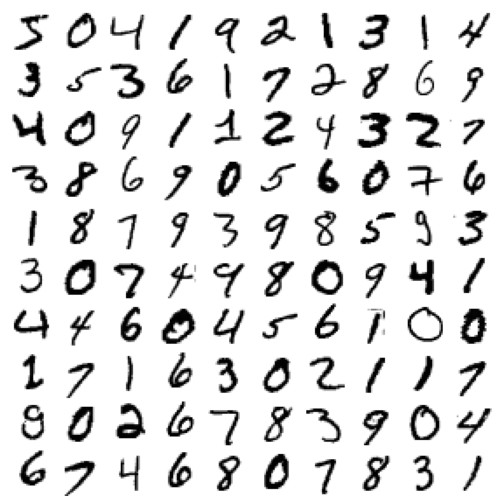

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, img_per_row=10)
# save_fig("more_digits_plot")
plt.show()

In [ ]:
# 60,000 for training, and 10,000 for test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# **Binary classifier (2 classes only) with Stochastic Gradient Descent (SGD)**

In [ ]:
# Only check if a image is "5" or not "5"
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
y_train_5[0:40]

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False])

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Check
id_pred   = 1
img_pred  = X[id_pred]
label_img = y[id_pred]

print('True number: {} '.format( label_img ) )
result = sgd_clf.predict([img_pred])

print('Is it "5"? {}'.format( result[0] ))

# Check another case
print()
id_pred   = 0
img_pred  = X[id_pred]
label_img = y[id_pred]

print('True number: {} '.format( label_img ) )
result = sgd_clf.predict([img_pred])

print('Is it "5"? {}'.format( result[0] ))

True number: 0 
Is it "5"? False

True number: 5 
Is it "5"? True


# **Performance Measures**

## *1. Measuring Accuracy Using Cross-Validation*

### *a. With Stratified K-fold*

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for (train_idx, test_idx) in skfolds.split(X_train, y_train_5):
    # create a clone of the SGD classifier
    clone_clf    = clone(sgd_clf)

    X_train_fold = X_train[train_idx]
    y_train_fold = y_train_5[train_idx]

    X_test_fold  = X_train[test_idx]
    y_test_fold  = y_train_5[test_idx]

    # Training
    clone_clf.fit(X_train_fold, y_train_fold)
    
    # Predict
    y_pred = clone_clf.predict(X_test_fold)
    
    # Result
    n_correct = sum(y_pred == y_test_fold)

    print('Result: {:6.4f}'.format( n_correct / len(y_pred) ))  # prints 0.9502, 0.96565, and 0.96495

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Result: 0.9504
Result: 0.9604
Result: 0.9604


### *b. With cross_val_score(): K-fold cross-validation with three folds (meaning splitting the training set into K folds)*

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## *2. Confusion Matrix*

In [ ]:
# Just like the cross_val_score() function, cross_val_predict() performs
# K-fold cross-validation, but instead of returning the evaluation scores,
# it returns the predictions made on each "test" fold (Not test dataset).
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# pretend we reached perfection
y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**precision = TP / (TP+FP)**



**recall    = TP / (TP+FN)**

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**F1_score = 2 / [1/precision + 1/recall]**

**= 2 x [precision x recall] / [precision + recall]**

**= TP/ [ TP + [(FN+FP)/2]**

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
some_digit = X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

**Precision/Recall Trade-off: increasing the threshold reduces recall and increases precision, and vice-versa.**

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
print( 'is it "5" ?', y_some_digit_pred )
print( 'true digit: ', y[0] )

is it "5" ? [ True]
true digit:  5


In [ ]:
# Let’s raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

print( 'is it "5" ?', y_some_digit_pred )
print( 'true digit: ', y[0] )

is it "5" ? [False]
true digit:  5


**How do you decide which threshold to use?**

**Step 1: use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:**

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3,
                             method="decision_function")

**Step 2: With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:**

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Step 3: Plot precision and recall as functions of the threshold value**

Saving figure precision_recall_vs_threshold_plot


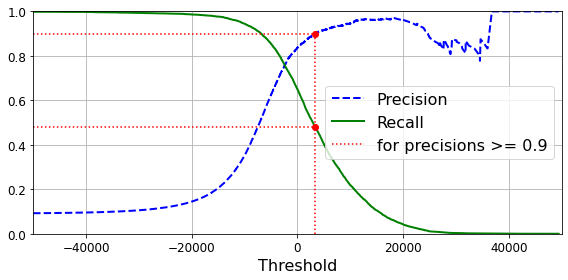

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    # plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:", label="for precisions >= 0.9")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.legend(loc="center right", fontsize=16)                         
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

Saving figure precision_vs_recall_plot


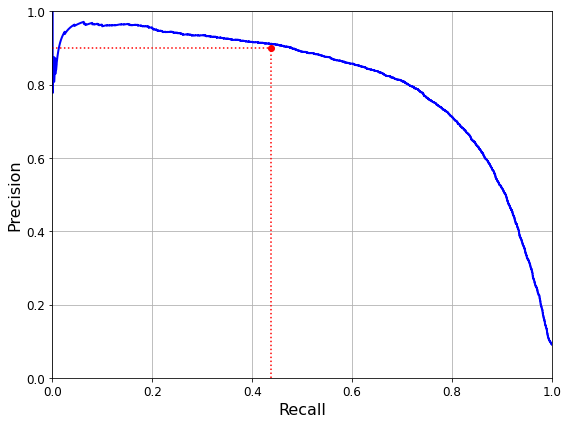

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## *3. The ROC Curve*

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces.
# The dotted line represents the ROC curve of a purely random classifier;
# a good classifier stays as far away from that line as possible (toward the top-left corner).

Saving figure roc_curve_plot


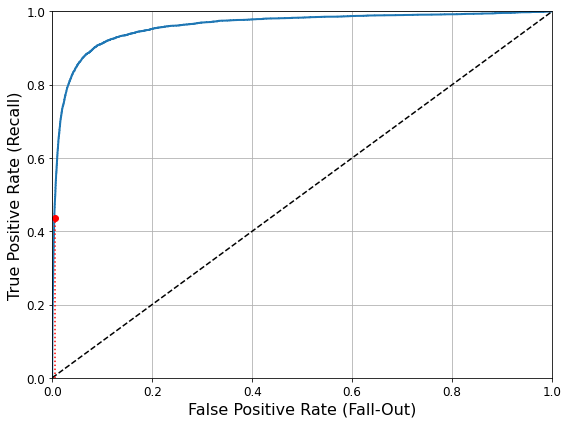

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
save_fig("roc_curve_plot")                         
plt.show()

**Note**: A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## **Comapre with the Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)          # n_estimators: Number of trees in Random forest
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


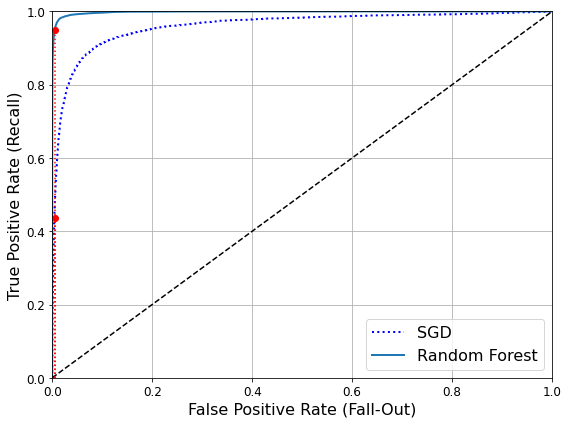

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591